In [210]:
from google.colab import drive
import gensim
import keras
from keras import metrics

In [211]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [212]:
%cd "/content/drive/My Drive/1_processing/w2v_cnn"

/content/drive/My Drive/1_processing/w2v_cnn


In [213]:
import pandas as pd
import numpy as np
import pickle

In [214]:
import spacy 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [215]:
from tensorflow.python.keras.metrics import Metric

In [216]:
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D,MaxPooling2D, GlobalMaxPooling2D
from tensorflow.python.keras.layers import Reshape, Flatten, Dropout, Concatenate,BatchNormalization
from keras.layers.core import Reshape
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.optimizers import Adam,SGD,Adadelta, Adagrad
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import regularizers
# from tensorflow.keras.callbacks import EarlyStopping
# tf.compat.v1.disable_eager_execution()

In [1138]:
with open('mutated.pkl', 'rb') as input_file:
    mutated = pickle.load(input_file)   
print(mutated.columns)
mutated.shape

Index(['repo_count', 'task_name', 'method_description', 'mod_keys_found',
       'mod_values_found', 'key_module_text', 'value_module_text',
       'mod_keys_found_string', 'found_used_parameters', 'has_params',
       'third_ast', 'third_tokens', 'token_task_names', 'descr_one_string',
       'consistent', 'task_com', 'task_complete'],
      dtype='object')


(20792, 17)

In [1139]:
with open('top10_list.pkl', 'rb') as input_file:
    top10_list = pickle.load(input_file)   
top10_list

['shell',
 'command',
 'set_fact',
 'template',
 'file',
 'gather_facts',
 'copy',
 'service',
 'debug',
 'fail']

In [1140]:
mutated = mutated[mutated['mod_keys_found_string'] == 'template']
mutated.shape

(2396, 17)

In [1141]:
train_set, val_set, test_set = np.split(mutated.sample(frac=1), [int(.6*len(mutated)), int(.8*len(mutated))])

In [1142]:
print(train_set.shape)
print(val_set.shape)
test_set.shape

(1437, 17)
(479, 17)


(480, 17)

In [1143]:
# train_set = train_set.reset_index(drop=True)
# test_set = train_set.reset_index(drop=True)
# val_set = train_set.reset_index(drop=True)

<h4>Word2vec</h4>




In [1144]:
tasks_sent_train = [row for row in train_set['task_complete']]

In [1145]:
model_tasks3 = Word2Vec(tasks_sent_train, sg = 0, size=100, window=6, min_count=1, workers=4, iter= 1000)

<h4>CNN</h4>

In [1146]:
def list_to_string(lst):

  one_string = ' '.join(lst)

  return one_string

In [1147]:
train_set['task_complete_one_string'] = train_set['task_complete'].apply(lambda x: list_to_string(x))
test_set['task_complete_one_string'] = test_set['task_complete'].apply(lambda x: list_to_string(x))
val_set['task_complete_one_string'] = val_set['task_complete'].apply(lambda x: list_to_string(x))

In [1148]:
# train_set['task_complete_one_string'][11548]

In [1149]:
y_train = train_set['consistent'].astype(int)
print(y_train.value_counts(),y_train.shape)

y_test = test_set['consistent'].astype(int)
print(y_test.value_counts(),y_test.shape)

y_val = val_set['consistent'].astype(int)
print(y_val.value_counts(),y_val.shape)

1    727
0    710
Name: consistent, dtype: int64 (1437,)
0    249
1    231
Name: consistent, dtype: int64 (480,)
1    240
0    239
Name: consistent, dtype: int64 (479,)


In [1150]:
test_set.shape

(480, 18)

In [1152]:
word_vectors = model_tasks3.wv
type(word_vectors)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [1153]:
len(word_vectors.vocab)

5018

In [1154]:
tokenizer_train = Tokenizer(lower=False) 
tokenizer_train.fit_on_texts(train_set['task_complete'])
print(tokenizer_train)

tokenizer_test = Tokenizer(lower=False) 
tokenizer_test.fit_on_texts(test_set['task_complete'])
print(tokenizer_test)

tokenizer_val = Tokenizer(lower=False) 
tokenizer_val.fit_on_texts(val_set['task_complete'])
tokenizer_val

In [1155]:
list(tokenizer_train.word_index)[0:10]

['AnsibleTask',
 'TaskName',
 'TaskDescription',
 'template',
 'dest',
 'src',
 'file',
 'when',
 'True',
 'notify']

In [1156]:
print("len(tokenizer) :",len(list(tokenizer_train.word_index)))

len(tokenizer) : 5018


In [1157]:
tasks_train_tokens = tokenizer_train.texts_to_sequences(train_set['task_complete_one_string'])
tasks_test_tokens = tokenizer_test.texts_to_sequences(test_set['task_complete_one_string'])
tasks_val_tokens = tokenizer_val.texts_to_sequences(val_set['task_complete_one_string'])

In [1158]:
# print(tasks_train_tokens[800])

In [1159]:
num_tokens = [len(tokens) for tokens in tasks_train_tokens]
num_tokens = np.array(num_tokens)

In [1160]:
len(num_tokens)

1437

In [1161]:
np.max(num_tokens)

139

In [1162]:
np.argmax(num_tokens)

1210

In [1164]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

51

In [1165]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9554627696590118

In [1166]:
tasks_train_pad = pad_sequences(tasks_train_tokens, maxlen=max_tokens,padding='post')
tasks_test_pad = pad_sequences(tasks_test_tokens, maxlen=max_tokens,padding='post')
tasks_val_pad = pad_sequences(tasks_val_tokens, maxlen=max_tokens,padding='post')

In [1167]:
tasks_train_pad.shape[0]

1437

In [1168]:
print("x_train_tokens :",tasks_train_tokens[0])
print("x_train_pad :",tasks_train_pad[0])

x_train_tokens : [1, 2, 14, 12, 381, 84, 20, 51, 3, 71, 24, 381, 51, 4, 6, 33, 5, 570, 35, 83, 381, 381, 84, 165, 13, 9, 100, 749, 628, 570, 346, 35, 381, 529, 381, 84, 570, 346, 35, 381, 381, 84, 570, 346, 35, 381, 84, 381, 84, 8, 529, 23, 36, 24, 19, 24, 145, 25, 10, 29, 381, 45]
x_train_pad : [381  51   4   6  33   5 570  35  83 381 381  84 165  13   9 100 749 628
 570 346  35 381 529 381  84 570 346  35 381 381  84 570 346  35 381  84
 381  84   8 529  23  36  24  19  24 145  25  10  29 381  45]


In [1169]:
print("x_train_pad.shape :",tasks_train_pad.shape)

x_train_pad.shape : (1437, 51)


In [1170]:
idx = tokenizer_train.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [1171]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [1173]:
embedding_size = 100

In [1174]:
num_words = len(list(tokenizer_train.word_index))+1
num_words

5019

In [1175]:
embedding_matrix = np.random.uniform(-1, 1, (num_words, embedding_size))
for word, i in tokenizer_train.word_index.items():
    if i < num_words:
        embedding_vector = model_tasks3[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [1176]:
embedding_matrix.shape

(5019, 100)

In [1177]:
embedding_matrix

array([[-0.88539008, -0.81474974, -0.17423336, ...,  0.24740552,
         0.42738232,  0.81563106],
       [-0.94099486,  1.74128103,  2.87256718, ...,  4.27785015,
        -4.63165283, -3.41396356],
       [ 2.36465836,  1.29765427,  2.10157108, ...,  2.28315616,
        -3.77031183, -1.92244136],
       ...,
       [-0.46344689,  0.53325528,  0.98430526, ..., -0.42692557,
        -0.60548502, -0.72591448],
       [-0.13080975, -0.03138974,  0.18106954, ...,  0.133011  ,
        -0.55444998, -0.04984037],
       [-0.13481465, -0.11191131,  0.02377787, ...,  0.23642012,
        -0.42002228,  0.15169679]])

In [1178]:
sequence_length = max_tokens
vocabulary_size = num_words
embedding_dim = embedding_size
filter_sizes = [3,4,5]
batch_size = 256
# num_filters = 512
# drop = 0.5

In [1179]:
embedding_layer = Embedding(input_dim=num_words,output_dim=embedding_size,weights= [embedding_matrix],input_length=max_tokens, trainable=False,name='embedding_layer')
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
embedding

<tf.Tensor 'embedding_layer_32/embedding_lookup/Identity_1:0' shape=(None, 51, 100) dtype=float32>

In [1181]:
sample_size = tasks_train_pad.shape
print(sample_size)
print(len(tasks_train_pad[0]))

(1437, 51)
51


In [1184]:
#CNN architecture

num_classes = 2

#Training params
# batch_size = 256 
num_epochs = 20

#Model parameters
num_filters = 64  
embed_dim = embedding_size 
weight_decay = 1e-4

print("training CNN ...")
model = Sequential()

#Model add word2vec embedding

model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    weights= [embedding_matrix],
                    input_length=max_tokens,        
                    trainable=True,              #the layer is trained
                    name='embedding_layer'))
model.add(layers.Conv1D(filters = num_filters, kernel_size = max_tokens, activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.MaxPooling1D(2))
model.add(Dropout(0.25))

model.add(layers.Conv1D(filters = num_filters+num_filters, kernel_size = max_tokens, activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.GlobalMaxPooling1D())
model.add(Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
# model.add(BatchNormalization())
model.add(layers.Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer = sgd,metrics=['accuracy'])
model.summary()


history = model.fit(tasks_train_pad, to_categorical(y_train), batch_size=batch_size, epochs=num_epochs, validation_data=(tasks_test_pad, to_categorical(y_test)),
                 shuffle=True, verbose=2)

training CNN ...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 51, 100)           501900    
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 51, 64)            326464    
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 25, 64)            0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 25, 64)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 25, 128)           417920    
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 128)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 

In [1185]:
from matplotlib import pyplot

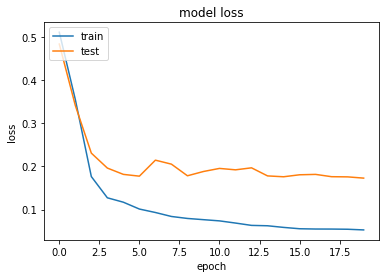

In [1188]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.savefig('loss/loss_template.jpg')
pyplot.show()

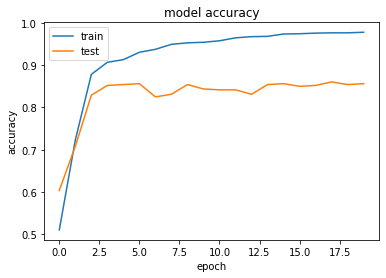

In [1191]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.savefig('accs/acc_template.jpg')
pyplot.show()

In [1192]:
score = model.evaluate(tasks_val_pad, to_categorical(y_val), verbose=0)

In [1193]:
print('loss:', score[0])
print('Validation accuracy:', score[1])

loss: 0.1497260175318708
Validation accuracy: 0.8830898


In [1194]:
y_pred=model.predict_classes(tasks_val_pad)

In [1195]:
from sklearn.metrics import confusion_matrix

In [1196]:
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[209  30]
 [ 26 214]]


In [1197]:
tp = cm[1][1]
fp = cm[0][1]
fn = cm[1][0]
tn= cm[0][0]
all_val = tp+fp+fn+tn

In [1198]:
precision = round(tp/(tp+fp),2)

In [1199]:
recall = round(tp/(tp+fn), 2)
recall

0.89

In [1200]:
f1_score = (2*precision*recall)/(precision+recall)
f1_score

0.8849717514124293

In [1201]:
precision_neg = round(tn/(tn+fn),2)
precision_neg

0.89

In [1202]:
recall_neg = round(tn/(tn+fp), 2)
recall_neg

0.87

In [1203]:
f1_score = (2*precision_neg*recall_neg)/(precision_neg+recall_neg)
f1_score

0.8798863636363636

In [1204]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [1205]:
ns_probs = [0 for _ in range(len(y_val))]

In [1206]:
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, y_pred)

In [1207]:
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Our model: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Our model: ROC AUC=0.883


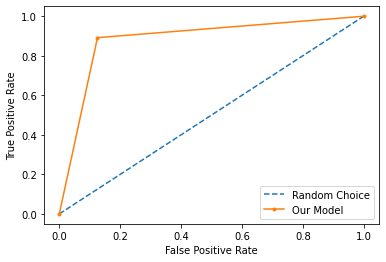

In [1208]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)

lr_fpr, lr_tpr, _ = roc_curve(y_val, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Choice')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Our Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
pyplot.savefig('rocs/roc_template.jpg')
# show the plot
pyplot.show()